In [2]:
# - This script loads the LIAR dataset
# - It trains multiple traditional ML models (Logistic Regression, Linear SVM, RandomForest,
#   MultinomialNB, XGBoost, Decision Tree, KNN) and reports comparison metrics for multiclass settings.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bdas2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. LOAD DATA

In [4]:
#Load LIAR dataset

column_names = [
    "id", "label", "statement", "subject", "speaker", "job_title",
    "state", "party", "barely_true_counts", "false_counts",
    "half_true_counts", "mostly_true_counts", "pants_on_fire_counts",
    "context"
]

train_df = pd.read_csv("train.tsv", sep='\t', names=column_names)
valid_df = pd.read_csv("valid.tsv", sep='\t', names=column_names)
test_df  = pd.read_csv("test.tsv",  sep='\t', names=column_names)

# Keep only label & statement
train_df = train_df[['label', 'statement']]
valid_df = valid_df[['label', 'statement']]
test_df  = test_df[['label', 'statement']]

# Combine train + valid
train_df = pd.concat([train_df, valid_df], ignore_index=True)
print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

Train shape: (11524, 2)
Test shape : (1267, 2)


In [5]:
train_df.head()

,label,statement
0,false,Says the Annies List political group supports ...
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
3,false,Health care reform legislation is likely to ma...
4,half-true,The economic turnaround started at the end of ...


### 2. EDA

In [8]:
print("\nLabel distribution in training data:")
print(train_df['label'].value_counts())


Label distribution in training data:
label
half-true      2362
false          2258
mostly-true    2213
barely-true    1891
true           1845
pants-fire      955
Name: count, dtype: int64



Unique Labels: ['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


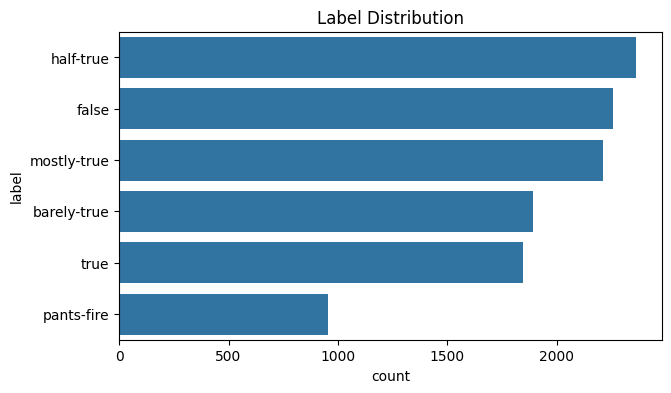

In [9]:
print("\nUnique Labels:", train_df['label'].unique())
plt.figure(figsize=(7,4))
sns.countplot(y=train_df['label'], order=train_df['label'].value_counts().index)
plt.title("Label Distribution")
plt.show()

### 3. TEXT CLEANING

In [10]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df['clean_text'] = train_df['statement'].apply(clean_text)
test_df['clean_text'] = test_df['statement'].apply(clean_text)

In [11]:
train_df.head()

,label,statement,clean_text
0,false,Says the Annies List political group supports ...,says the annies list political group supports ...
1,half-true,When did the decline of coal start? It started...,when did the decline of coal start it started ...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agrees with john mccain by vot...
3,false,Health care reform legislation is likely to ma...,health care reform legislation is likely to ma...
4,half-true,The economic turnaround started at the end of ...,the economic turnaround started at the end of ...


## 4. ENCODE LABELS

In [12]:
label_map = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}
inv_label_map = {v: k for k, v in label_map.items()}

train_df['label_id'] = train_df['label'].map(label_map)
test_df['label_id'] = test_df['label'].map(label_map)

In [13]:
train_df.head()

,label,statement,clean_text,label_id
0,false,Says the Annies List political group supports ...,says the annies list political group supports ...,1
1,half-true,When did the decline of coal start? It started...,when did the decline of coal start it started ...,2
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agrees with john mccain by vot...,3
3,false,Health care reform legislation is likely to ma...,health care reform legislation is likely to ma...,1
4,half-true,The economic turnaround started at the end of ...,the economic turnaround started at the end of ...,2


### 5. MODEL TRAINING

In [14]:
X_train, y_train = train_df['clean_text'], train_df['label_id']
X_test, y_test = test_df['clean_text'], test_df['label_id']

### 6. TEXT VECTORISATION (TF-IDF)

In [15]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=3, stop_words=list(stop_words))

### 7. MODEL TRAINING

In [16]:
from sklearn.pipeline import Pipeline
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Multinomial NB": MultinomialNB(),
    "SVM": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    pipe = Pipeline([
        ('tfidf', tfidf),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)

    results.append([name, acc, f1, prec, rec])
    print(f"Accuracy: {acc:.4f} | F1 Score (weighted): {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")
    print(classification_report(y_test, y_pred, target_names=[inv_label_map[i] for i in sorted(inv_label_map.keys())]))


Training Logistic Regression...
Accuracy: 0.2455 | F1 Score (weighted): 0.2378 | Precision: 0.2424 | Recall: 0.2455
              precision    recall  f1-score   support

 barely-true       0.26      0.18      0.21       212
       false       0.25      0.33      0.29       249
   half-true       0.24      0.28      0.26       265
 mostly-true       0.23      0.27      0.25       241
  pants-fire       0.18      0.03      0.06        92
        true       0.26      0.24      0.25       208

    accuracy                           0.25      1267
   macro avg       0.24      0.22      0.22      1267
weighted avg       0.24      0.25      0.24      1267


Training Random Forest...
Accuracy: 0.2320 | F1 Score (weighted): 0.2216 | Precision: 0.2358 | Recall: 0.2320
              precision    recall  f1-score   support

 barely-true       0.23      0.13      0.17       212
       false       0.25      0.38      0.30       249
   half-true       0.23      0.25      0.24       265
 mostly-true

C:\Users\bdas2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bdas2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bdas2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Accuracy: 0.2360 | F1 Score (weighted): 0.2340 | Precision: 0.2331 | Recall: 0.2360
              precision    recall  f1-score   support

 barely-true       0.21      0.19      0.20       212
       false       0.28      0.32      0.30       249
   half-true       0.23      0.23      0.23       265
 mostly-true       0.24      0.24      0.24       241
  pants-fire       0.15      0.12      0.13        92
        true       0.23      0.24      0.23       208

    accuracy                           0.24      1267
   macro avg       0.22      0.22      0.22      1267
weighted avg       0.23      0.24      0.23      1267


Training Decision Tree...
Accuracy: 0.2107 | F1 Score (weighted): 0.2094 | Precision: 0.2099 | Recall: 0.2107
              precision    recall  f1-score   support

 barely-true       0.19      0.17      0.18       212
       false       0.26      0.27      0.26       249
   half-true       0.21      0.19      0.20       265
 mostly-true       0.21      0.26      0.23  

### 8. MODEL TRAINING


=== Model Comparison ===
                 Model  Accuracy  F1-Score  Precision    Recall
0       Multinomial NB  0.248619  0.226333   0.233662  0.248619
1  Logistic Regression  0.245462  0.237813   0.242426  0.245462
2              XGBoost  0.239937  0.233309   0.240391  0.239937
3                  SVM  0.235991  0.233998   0.233052  0.235991
4        Random Forest  0.232044  0.221569   0.235812  0.232044
5                  KNN  0.217837  0.211459   0.212730  0.217837
6        Decision Tree  0.210734  0.209435   0.209856  0.210734


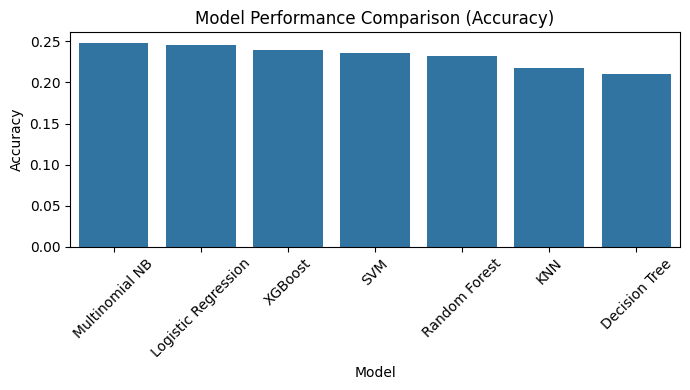

In [18]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1-Score', 'Precision', 'Recall'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print("\n=== Model Comparison ===")
print(results_df)

plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x='Model', y='Accuracy')
plt.title("Model Performance Comparison (Accuracy)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()